In [1]:
!cp /kaggle/input/bird-project/project/model.py .
!cp -r /kaggle/input/identify-the-birds .

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as v2

from sklearn.metrics import accuracy_score

from model import NeuralNet

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

In [4]:
image_transforms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale = True),
    v2.Resize((300, 300)), 
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomVerticalFlip(p = 0.2)
])

In [5]:
DATA_PATH = '/kaggle/working/identify-the-birds/Birds/train/'

In [6]:
data = torchvision.datasets.ImageFolder(DATA_PATH, transform = image_transforms)
train_data, validation_data = torch.utils.data.random_split(data, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 256, shuffle = True, num_workers = 0)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size = 256, shuffle = True, num_workers = 0)

In [7]:
print(device)

cuda


In [8]:
def get_accuracy(y_act, y_pred):
    
    predictions = np.argmax(y_pred, axis = 1)
    ground_truth = y_act
    
    accuracy = accuracy_score(ground_truth, predictions)
    
    return accuracy

In [9]:
net = NeuralNet().to(device)
net.initialize_weights()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
print([p.numel() for p in net.parameters()])
print(sum([p.numel() for p in net.parameters()]))

[432, 16, 6400, 16, 4608, 32, 9216, 32, 51200, 64, 36864, 64, 73728, 128, 147456, 128, 409600, 128, 294912, 256, 589824, 256, 589824, 256, 21233664, 1024, 131072, 128, 1280, 10, 32, 32, 128, 128, 128, 128]
23583194


In [11]:
train_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

In [12]:
def train_model(model, dataloader, loss_criterion, optimizer):

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model.forward(X)
        loss = loss_criterion(y_pred, y)
        loss.backward()
        optimizer.step()


def evaluate_model(model, dataloader, loss_criterion):

    y_pred = []
    y_act = []
    total_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_out = model.forward(X)
            loss = loss_criterion(y_out, y)
            total_loss += loss.item()
            y_pred.append(y_out.detach().cpu().numpy())
            y_act.append(y.detach().cpu().numpy())
            
    y_pred = np.concatenate(y_pred, axis = 0)
    y_act = np.concatenate(y_act, axis = 0)
    total_loss = total_loss / len(dataloader)
    accuracy = get_accuracy(y_act, y_pred)
    
    return total_loss, accuracy

In [13]:
nepochs = 20

for epoch in range(1, nepochs+1):
    
    net.train()
    train_model(net, train_loader, criterion, optimizer)
    
    net.eval()
    train_loss, train_accuracy = evaluate_model(net, train_loader, criterion)
    val_loss, val_accuracy = evaluate_model(net, validation_loader, criterion)
    
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    
    train_accuracy_values.append(train_accuracy)
    val_accuracy_values.append(val_accuracy)
    
    print('Epoch:', epoch)
    print('Train Loss:', train_loss, '||', 'Train Accuracy:', train_accuracy)
    print('Validation Loss:', val_loss, '||', 'Validation Accuracy:', val_accuracy)

Epoch: 1
Train Loss: 2.4625272899866104 || Train Accuracy: 0.15110441767068272
Validation Loss: 2.440527468919754 || Validation Accuracy: 0.16265060240963855
Epoch: 2
Train Loss: 1.7476776912808418 || Train Accuracy: 0.4157881526104418
Validation Loss: 1.7392109781503677 || Validation Accuracy: 0.39558232931726905
Epoch: 3
Train Loss: 1.4404345154762268 || Train Accuracy: 0.4864457831325301
Validation Loss: 1.4414231032133102 || Validation Accuracy: 0.49497991967871485
Epoch: 4
Train Loss: 1.2062531113624573 || Train Accuracy: 0.5520833333333334
Validation Loss: 1.2500647604465485 || Validation Accuracy: 0.5441767068273092
Epoch: 5
Train Loss: 0.9382283557206392 || Train Accuracy: 0.6731927710843374
Validation Loss: 0.983376257121563 || Validation Accuracy: 0.6666666666666666
Epoch: 6
Train Loss: 0.9283505324274302 || Train Accuracy: 0.6720632530120482
Validation Loss: 0.9643825441598892 || Validation Accuracy: 0.6596385542168675
Epoch: 7
Train Loss: 1.1828795950859785 || Train Accurac

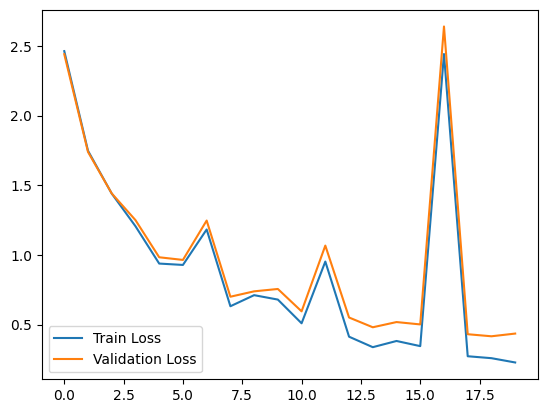

In [14]:
plt.plot(train_loss_values, label = 'Train Loss')
plt.plot(val_loss_values, label = 'Validation Loss')
plt.legend()
plt.show()

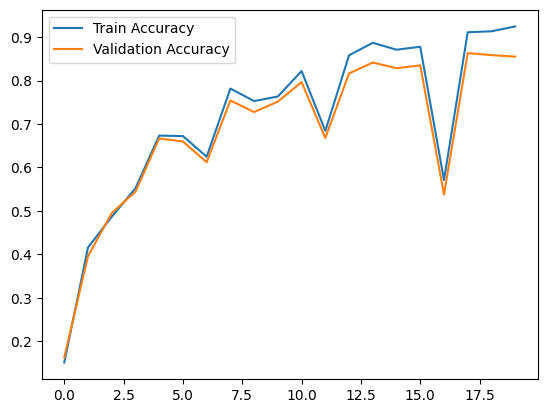

In [15]:
plt.plot(train_accuracy_values, label = 'Train Accuracy')
plt.plot(val_accuracy_values, label = 'Validation Accuracy')
plt.legend()
plt.show()

In [16]:
torch.save(net.state_dict(), './model_weights.pth')